# Image Classification using Convolution Neural Network


### import dependencies

In [1]:
import tensorflow as tf
import keras
import os # to navigate through file structure
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers # for data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from collections import Counter
from keras.utils import to_categorical
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential # the model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout #layer of that model
from sklearn.utils import class_weight
from keras.optimizers import Adam


tf.__version__

/Users/quangdong/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


'2.16.1'

In [2]:
!python --version

Python 3.10.14


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU') #grab all available gpus on our machine
for gpu in gpus: # limit the memory growth
    tf.config.experimental.set_memory_growth(gpu, True)

- avoid OOM errors
- limit the tenserflow so it won't use all of the vram on our gpu when loading data

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
batch_size = 32

### remove dogy image
remove corrupted, mislable image

In [6]:
import cv2
# import imghdr

In [7]:
data_dir = 'Furniture_Data'

- First, manually delete any image that has the size below 10 KB (it's too small)
- Next, remove dodgy images using loops

In [8]:
# image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
# image_count = 0 # initialize counter
# import os

# for image_class in os.listdir(data_dir): # loop through each folder and their sub-folder to count using os
#     class_path = os.path.join(data_dir, image_class)
#     if os.path.isdir(class_path):  # check if it's a directory
#         for image_sub in os.listdir(class_path):
#             sub_path = os.path.join(class_path, image_sub)
#             if os.path.isdir(sub_path):  # check if it's a directory
#                 for image in os.listdir(sub_path):
#                     image_path = os.path.join(sub_path,image)
#                     # print(image)
#                     image_count += 1
            
# print("Total images:", image_count) 

In [10]:
# for image_class in os.listdir(data_dir): # loop through each folder and their sub-folder to count using os
#     class_path = os.path.join(data_dir, image_class)
#     if os.path.isdir(class_path):  # check if it's a directory
#         for image_sub in os.listdir(class_path):
#             sub_path = os.path.join(class_path, image_sub)
#             if os.path.isdir(sub_path):  # check if it's a directory
#                 for image in os.listdir(sub_path):
#                     image_path = os.path.join(sub_path,image)
#                     try: 
#                         img = cv2.imread(image_path) # read image information
#                         tip = imghdr.what(image_path)
#                         if tip not in image_exts: 
#                             print('Image not in ext list {}'.format(image_path))
#                             #os.remove(image_path)
#                     except Exception as e: 
#                         print('Issue with image {}'.format(image_path))
#                         # os.remove(image_path)

There is no dodgy image to remove

This show the information of the image: 224 pixels high, 224 pixels wide, 3 = color)

### Load + Preprocessing data
For such a large dataset, an on-the-fly loading mechanism is recommanded rather than loading all data into memory at once.  
ImageDataGenerator is a input pipeline, you can use it to feed data directly to the model without storing huge ass data to the memory

https://viblo.asia/p/xay-dung-input-pipeline-cho-du-lieu-dang-anh-voi-tensoflow-keras-maGK7GnOKj2

load data with shuffel image

validation dataset is test dataset
https://www.kaggle.com/discussions/questions-and-answers/251631

In [11]:
Datagen = ImageDataGenerator( # template to call data (preprocessing)
    rescale=1./255, #scaling
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4) # set validation split

train_generator = Datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical', # this parameter affect the label(output) shape
    subset='training') # set as training data


# Calculate class weights
counter = Counter(train_generator.classes)
max_val = float(max(counter.values()))
class_weights = {class_id: max_val/num_images for class_id, num_images in counter.items()}


validation_generator = Datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data



Found 54050 images belonging to 6 classes.
Found 36032 images belonging to 6 classes.


**One-hot encoding vs Integer encoding:**

The choice is one-hot encoding since integer encoding can introduce a bias into the data by implying a natural ordering between the categories. This can lead to poor performance or unexpected results in machine learning models that use the encoded data (class_mode = 'categorical').

https://medium.com/geekculture/machine-learning-one-hot-encoding-vs-integer-encoding-f180eb831cf1  
https://stackoverflow.com/questions/59439128/what-does-class-mode-parameter-in-keras-image-gen-flow-from-directory-signify

**Check and plot some images:**

In [12]:
first_item = train_generator.__getitem__(1) #check the first item
first_item[1].shape

(32, 6)

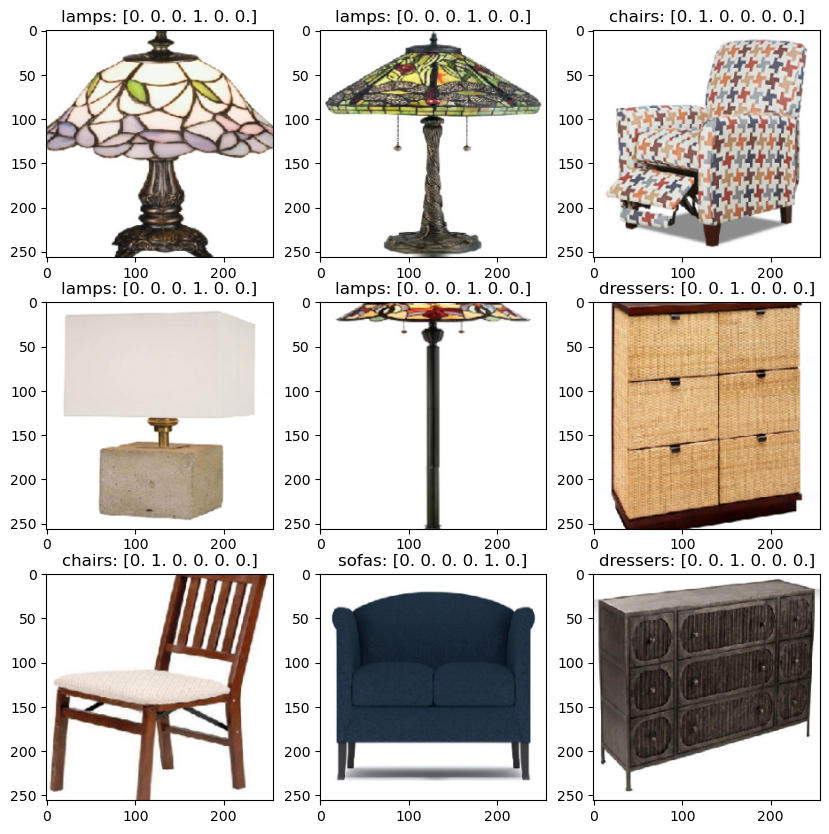

In [24]:
images, labels = next(train_generator)  # Get one batch of images and labels
class_names = list(train_generator.class_indices.keys())
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    plt.title(f"{class_names[label_index]}: {labels[i]}")  # Display the class name and one-hot encoded label
plt.show()

Since I use one-hot encoding, here are the labels:
- (1.0.0.0.0.0): beds
- (0.1.0.0.0.0): chairs
- (0.0.1.0.0.0): dressers
- (0.0.0.1.0.0): lamps
- (0.0.0.0.1.0): sofas
- (0.0.0.0.0.1): tables

### Data distribution

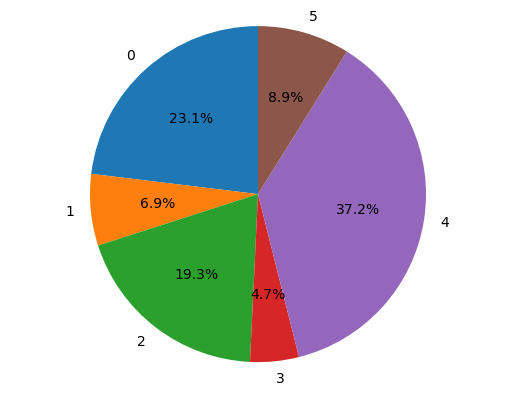

In [14]:
import matplotlib.pyplot as plt

class_weights
labels = class_weights.keys()
sizes = class_weights.values()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


**Conclusion:**
The classes in train data are highly imbalanced

**Solution:** 
- Class_weights: I will use the class_weights argument in model.fit (make the model learn more from the minority class).
- Data Augmentation: feed the model with new image every batch

**Other sugestions:**
- Upsampling: Using data augmentation to upsampling minority class (don't know how)
- Oversampling: it requires 2D input but using pipeline the image input is 4D, reshape would destroy image information (not recommand)
- Macro F1 score as loss function: F1 score can't be used for keras (if you want you need to create your own F1)

https://stackoverflow.com/questions/53666759/use-smote-to-oversample-image-data  
https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator  
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html  
https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

## Data Augmentation
 
 **Data augmentation inside a pipeline:** to ensure that the model sees “new” images that it has never “seen” before at each and every epoch (model will not see the same image).  
 **How does it work:** it accepts the original data, randomly transforms it, and returns only the new, transformed data.

In [15]:
# Defining data augmentation layer
data_augmentation = keras.Sequential([
        keras.layers.RandomFlip("horizontal_and_vertical"),
        keras.layers.RandomRotation(0.5),
        keras.layers.RandomContrast(0.5)
        ])

2024-05-15 12:10:11.414078: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-15 12:10:11.414106: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-15 12:10:11.414111: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-15 12:10:11.414134: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-15 12:10:11.414150: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Model

In [16]:
optimizer_A = Adam(learning_rate=0.001)
def CNN_model(IMG_WIDTH, IMG_HEIGHT):
    model = keras.Sequential() 
    # Data augmentation layer
    model.add (data_augmentation)
    # Convolutional layers
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(IMG_WIDTH,IMG_HEIGHT,3))) # specify the input shape in the first layer
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    # Flatten layer to transition from convolutional to fully connected layers
    model.add(Flatten())
    # Fully connected layers
    model.add(Dense(256, activation='relu'))
    # Output (6 outputs)
    model.add(Dense(6, activation='softmax')) # for multiclass classification, use Softmax
    # Compile
    model.compile(optimizer=optimizer_A, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['categorical_accuracy'])
    return model

available metric: https://stackoverflow.com/questions/59353009/list-of-metrics-that-can-be-passed-to-tf-keras-model-compile

# Train

In [17]:
logdir='logs' # create a logs folder (for check point)

In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) # (for check point)

In [19]:
model1 = CNN_model(IMG_HEIGHT, IMG_WIDTH)
model1.summary()

/Users/quangdong/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

The summary gives us a layer-by-layer description of the network. Notice that CNN has 3 convolutional layers. It was previously trained on over 90,000 of images, and has over 3,600,000 weights and biases, the majority of which connect to the first fully-connected layer (dense). CNN is setup to take a fixed-size (254 x 254 x 3) RGB image at its input, and then forward it through a series of altrnating convolutional and max-pooling layers, then capped off by three fully-connected layers of 256 and 6 neurons, where the last layer is our softmax classification layer.

Notice that the output shape at each layer has None the first dimension. This is because the network can process multiple images in a single batch. So if you forward 5 images at shape [5, 224, 224, 3], then the output shape at each layer will be 5 in the first dimension.

In [20]:
hist_model1 = model1.fit(train_generator, 
                    epochs=10, 
                    validation_data=validation_generator,
                    class_weight = 'balanced', 
                    callbacks=[tensorboard_callback])

AttributeError: 'str' object has no attribute 'get'

**Evaluation:**

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
plot_history(hist_model1)

# Hyper parameters tunning

# Evaluation
for the choosen model with test data (unseen data) 

# Test

task 1: 

In [ ]:
#load random image from dataset
images, labels = next(train_generator)  # Get one batch of images and labels
raw_image = images[1]
plt.imshow(raw_image)
plt.show()
#preprocess the image
resize = tf.image.resize(raw_image, (256,256))
sample_image = np.expand_dims(resize/255.0, 0)
#predicted array
prediction = DA_CNN.predict(sample_image)
# Convert prediction probabilities to percentages
percentage_predictions = [round(i * 100, 2) for i in prediction[0]]
print ("predicted percentages ",percentage_predictions)

# save model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
DA_CNN.save(os.path.join('models','imageclassifier.h5'))
 
# Output confirmation message
print("Model saved successfully.")

Task 2:

task 3: Multi-Label Image Classification Model (1 input - multiple outputs)